# The Trigger Function

## Transforming Continuous Preferences into Discrete Events

This notebook is a mathematical deep dive into the derivation of the Trigger Function used in Conviction Voting for the 1Hive use case.

The role of the trigger function in the conviction voting algorithm is to determine if a sufficient amount of conviction has accumulated in support of a particular proposal, at which point it passes from being a candidate proposal to an active proposal. 

In the 1Hive use case for conviction, proposals map to precise quantities of resources $r$ requested from a communal resource pool $R$ (which is time varying $R_t$ but we will drop the subscript for ease of reading). Furthermore, there is a supply of governance tokens $S$ which are being used as part of the goverance process.  In the implementation the quantity $S$ will be the effective supply which is the subset of the total Supply for the governance token in question. 

We assume a time varying supply $S_t$ and therefore we can interpret $S_t$ as the effective supply without loss of generality. From here forward, we will drop the subscript and refer to $S$ for ease of reading. The process of passing a proposal results in an allocation of $r$ funds as shown in the figure below.

![](images/stockflow_cv_trigger.png)

This diagram shows the trigger function logic, which depends on token supply $S$, total resources available $R$ and total conviction $y$ at time $t$, as well as the proposal's requested resources $r$, the maximum share of funds a proposal can take ($\beta$) and a tuning parameter for the trigger function ($\rho$). Essentially, this function controls the maximum amount of funds that can be requested by a proposal ($\beta$), using an equation resembling electron repulsion to ensure conviction increases massively beyond that point, so that no proposals may request more than $\beta$ share of total funds.

<br>

## Parameter Definition

* $\alpha \in (0,1)$ is the parameter that determines the half life decay rate of conviction, as defined in the [Deriving Alpha notebook](https://nbviewer.jupyter.org/github/BlockScience/Aragon_Conviction_Voting/blob/master/models/v3/Deriving_Alpha.ipynb) and should be tuned according to a desired half life.

* $\beta\in (0,1)$ is the max % of total funds that can be discharged by a single proposal, and is the asymptotic limit for the trigger function. It is impossible to discharge more than $\beta$ share of funds. 

* $\rho \in (0, \beta^2)$ is a the scale factor for the trigger function. Note that we require $0<\rho <\beta^2$  

The trigger function is defined by: $y^*(r) = \frac{\rho S}{(1-\alpha)\left(\beta - \frac{r}{R}\right)^2 }$

The geometric properties of this function with respect to the parameter choices are shown here:

![](images/trigger_geometry.png)

On this plot we can see that there is a maximum conviction that can be reached for a proposal, and also a maximum achievable funds released for a single proposal, which are important bounds for a community to establish for their funding pool. 

Note that by requiring that: $0<\rho <\beta^2$ the following holds $0<\frac{\rho}{\beta^2}<1$ and $0<\beta - \sqrt \rho <\beta <1$

## Initializing Conditions for Plot Series

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import inspect

import warnings
warnings.filterwarnings("ignore")

from cadCAD.configuration.utils import config_sim
from model.parts.utils import *
from model.parts.sys_params import * 

In [2]:
initial_values

{'sentiment': 0.6, 'n': 30, 'm': 7, 'funds': 4867.21, 'supply': 22392.22}

In [3]:
params

{'beta': [0.2],
 'rho': [0.0025],
 'alpha': [0.7937005259840998],
 'gamma': [0.001],
 'sensitivity': [0.75],
 'tmin': [1],
 'min_supp': [1],
 'base_completion_rate': [45],
 'base_failure_rate': [180],
 'base_engagement_rate': [0.3],
 'lowest_affinity_to_support': [0.3]}

In [4]:
supply = initial_values['supply']
funds = initial_values['funds']

alpha = params['alpha'][0]
beta = params['beta'][0]
rho = params['rho'][0]


In [5]:
def trigger(requested, funds, supply, alpha, beta, rho):
    '''
    Function that determines threshold for proposals being accepted.
    Refactored slightly from built in to be explicit for demo
    '''
    share = requested/funds
    if share < beta:
        threshold = rho*supply/(beta-share)**2  * 1/(1-alpha)
        return threshold 
    else: 
        return np.inf

The actual trigger function used in the V3 simulation is below:

In [6]:
trigger_simulation = inspect.getsource(trigger_threshold)
print(trigger_simulation)

def trigger_threshold(requested, funds, supply, alpha, params):
    '''
    Description:
    Function that determines threshold for proposals being accepted. 

    Parameters:
    requested: float, funds requested
    funds: float, funds
    supply: float
    alpha: float
    params: dictionary of parameters as floats

    Returns:
    Threshold value
    '''

    share = requested/funds
    if share < params['beta']:
        threshold = params['rho']*supply/(params['beta']-share)**2  * 1/(1-alpha)
        return threshold 
    else: 
        return np.inf



## Simple derivations
We can plug in some boundary conditions to determine our minimum required and maximum achievable conviction. We can also determine the maximum achievable funds a proposal is able to request, to understand the upper bounds of individual proposal funding.

* min_required_conviction = $y^*(0) = \frac{\rho S}{(1-\alpha)\beta^2}$
* max_achievable_conviction = $\frac{S}{1-\alpha}$
* min_required_conviction_as_a_share_of_max = $\frac{\rho S}{(1-\alpha)\beta^2} \cdot \frac{1-\alpha}{S} = \frac{\rho}{\beta^2}$
* To compute the max_achievable_request solve: $\frac{S}{1-\alpha} = \frac{\rho S}{(1-\alpha)\left(\beta-\\frac{r}{R}\right)^2}$
* max_achievable_request = $r = (\beta -\sqrt\rho)F$

In [7]:
min_required_conviction = trigger(0, funds, supply, alpha, beta, rho)
print("min_required_conviction = "+str(min_required_conviction))

max_achievable_conviction = supply/(1-alpha)
print("max_achievable_conviction = "+str(max_achievable_conviction))
print("")
print("min_achievable_conviction_as_a_share_of_max_achievable_conviction = "+str(min_required_conviction/max_achievable_conviction))
print("")
max_request = beta*funds
max_achievable_request = (beta - np.sqrt(rho))*funds
print("max_achievable_request = "+str(max_achievable_request))
print("total_funds = "+str(funds))
print("")
print("max_achievable_request_as_a_share_of_funds = "+str(max_achievable_request/funds))

granularity = 100 

requests = np.arange(0,.9*max_request, max_request/granularity)
requests_as_share_of_funds = requests/funds
conviction_required = np.array([trigger(r, funds, supply, alpha, beta, rho) for r in requests])
conviction_required_as_share_of_max = conviction_required/max_achievable_conviction


min_required_conviction = 6783.893932236272
max_achievable_conviction = 108542.30291578037

min_achievable_conviction_as_a_share_of_max_achievable_conviction = 0.06249999999999999

max_achievable_request = 730.0815000000001
total_funds = 4867.21

max_achievable_request_as_a_share_of_funds = 0.15000000000000002


## Plot series 1: Examining the Shape of the Trigger Function Compared to Absolute Funds Requested 

These plots demonstrate the trigger function shape, showing how the amount of conviction required increases as amount of requested (absolute) funds increases.  These plots are based on alpha, Supply and Funds as initialized above.

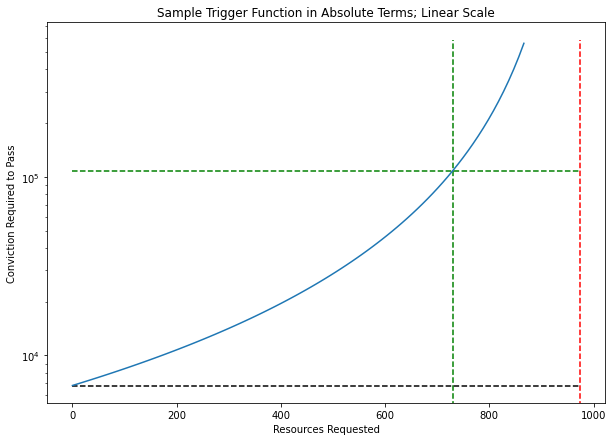

In [8]:
shape_of_trigger_in_absolute_terms(requests, conviction_required,max_request,
                                      max_achievable_request,max_achievable_conviction,
                                      min_required_conviction)

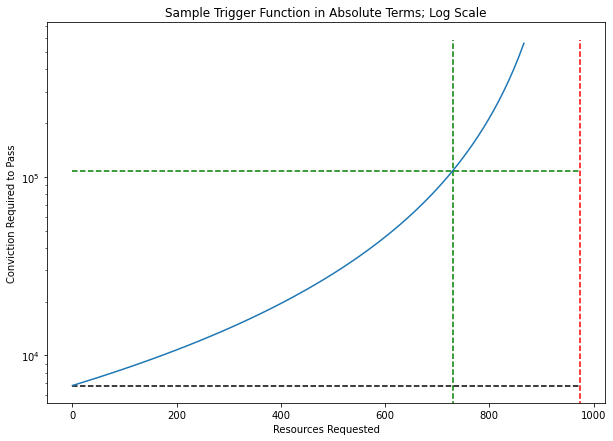

In [9]:
shape_of_trigger_in_absolute_terms(requests, conviction_required,max_request,
                                      max_achievable_request,max_achievable_conviction,
                                      min_required_conviction,log=True)

The above plots look at the shape of the trigger function on a linear and log scale, where you can see conviction required to pass a proposal increase with the absolute amount of funds requested. 

## Plot series 2: Examining the Shape of the Trigger Function Compared to Relative Funds Requested 

These plots demonstrate the trigger function shape, showing how the amount of conviction required increases as the **proportion** of requested  funds (relative to total funds) increases.  These plots are based on alpha, Supply and Funds as initialized above.

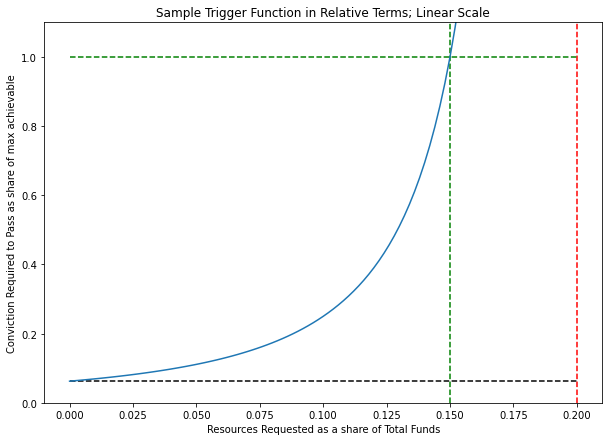

In [10]:
shape_of_trigger_in_relative_terms(requests_as_share_of_funds, conviction_required_as_share_of_max
                                       ,max_request, funds, max_achievable_request,
                                       max_achievable_conviction,
                                       min_required_conviction)

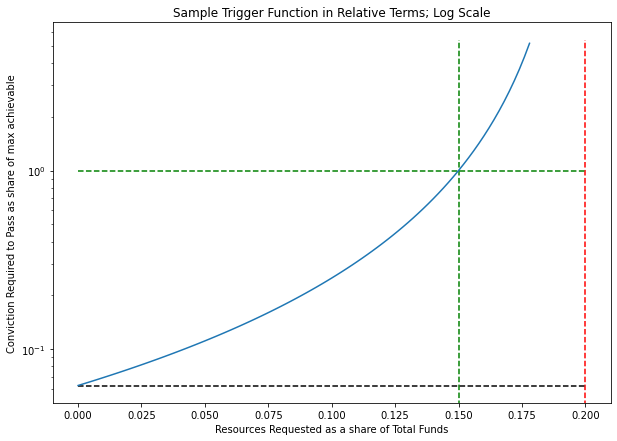

In [11]:
shape_of_trigger_in_relative_terms(requests_as_share_of_funds, conviction_required_as_share_of_max
                                       ,max_request, funds, max_achievable_request,
                                       max_achievable_conviction,
                                       min_required_conviction,log=True)

The above plots look at the shape of the trigger function on a linear and log scale, where you can see conviction required to pass a proposal increase with the percentage of total funds requested. The two green lines intersect at persistent, unanimous support for a proposal, and the maximum that can be requested (in this case) is 15% of the total pool of funds.

## Plot series 3: Heat Maps

The next set of plots show that conviction required  increases to a maximum with the proportion of total funds requested, capping out (in this case) at 15% of total funds available. Note that since we are using **relative** funds requested, these plots are invariant to alpha and effective supply. (In other words, since we are only looking at funds requested relative to the total funds, which are both affected by changes in alpha or effective supply, our conviction required for relative funds requested remains unchanged)

In [12]:
params

{'beta': [0.2],
 'rho': [0.0025],
 'alpha': [0.7937005259840998],
 'gamma': [0.001],
 'sensitivity': [0.75],
 'tmin': [1],
 'min_supp': [1],
 'base_completion_rate': [45],
 'base_failure_rate': [180],
 'base_engagement_rate': [0.3],
 'lowest_affinity_to_support': [0.3]}

In [13]:
supply_sweep = trigger_sweep('effective_supply',trigger, params, supply)

In [14]:
alpha_sweep = trigger_sweep('alpha',trigger, params, supply)

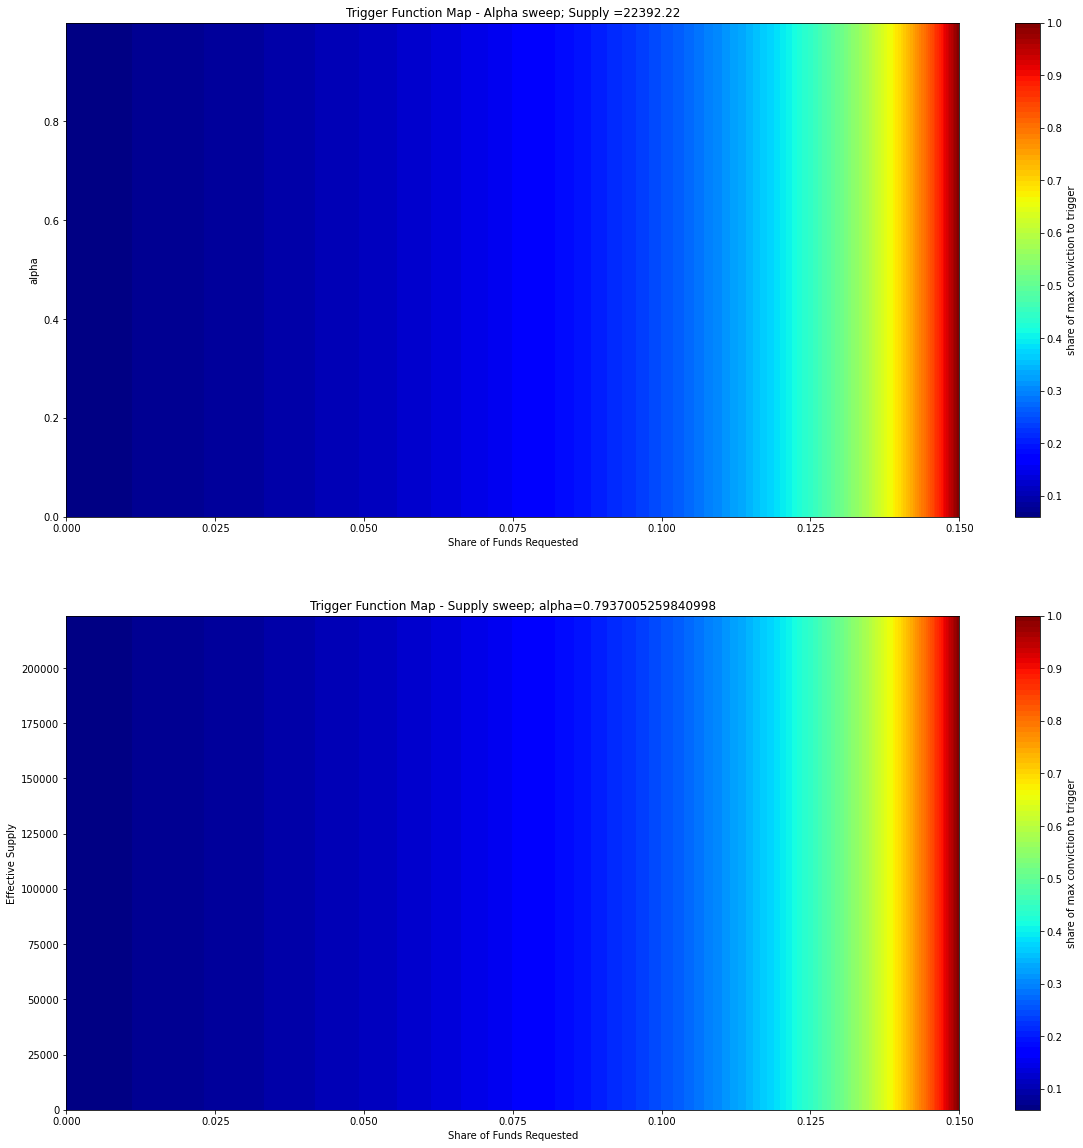

In [15]:
trigger_grid(supply_sweep, alpha_sweep)

## Conclusion

We recommend that implementers take careful consideration of their choices of the $\beta$ (% of total funds that can be requested) and $\rho$ (scaling factor) parameters, as these will have a high impact on your system design. $\alpha$ and other parameters are calculable from these parameters, but matter less when considering proposals requesting relative share of total funds.

To get a feel for how $\beta$ and $\rho$ impact the trigger function, play around with this [desmos graph](https://www.desmos.com/calculator/yxklrjs5m3). (Note: this is just a tool to play with the curve shape, don't be confused by variable names! $\rho$ is w in the calculator, due to the lack of greek characters ;)
